This notebook performs some exploratory analysis on the merged energy consumption, generation & pricing dataset.

In [50]:
import sys
import os

print("--- Python Executable ---")
# 현재 노트북이 사용하고 있는 파이썬의 정확한 위치
print(sys.executable)
print("\n" + "="*50 + "\n")

print("--- Current Working Directory ---")
# 현재 코드가 실행되고 있는 폴더의 위치
print(os.getcwd())
print("\n" + "="*50 + "\n")

print("--- Installed Packages (pip list) ---")
# 현재 파이썬 환경에 설치된 모든 라이브러리 목록
# 이 목록에 'src' 또는 프로젝트 이름이 있는지 확인해야 합니다.
!pip list

# 현재 위치에서 두 단계 상위 폴더로 작업 디렉토리를 변경
os.chdir('../../')

# 변경된 작업 디렉토리 확인
print("Changed Working Directory to:", os.getcwd())

--- Python Executable ---
c:\Users\Daniel\anaconda3\envs\aiot\python.exe


--- Current Working Directory ---
c:\


--- Installed Packages (pip list) ---
Package                           Version
--------------------------------- --------------
absl-py                           2.1.0
adafruit-io                       2.8.0
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aiosignal                         1.2.0
anyio                             4.5.0
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asttokens                         3.0.0
astunparse                        1.6.3
async-lru                         2.0.4
async-timeout                     4.0.3
attrs                             24.2.0
Babel                             2.11.0
backcall                          0.2.0
beautifulsoup4                    4.12.3
bleach                            6.1.0
blinker                       

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.eda.time_plot import time_plot
from src.eda.seasonal_plots import seasonal_plot1, seasonal_plot2, seasonal_plot3
from src.eda.autocorrelation import plot_autocorrelation

In [52]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [53]:
data_dir = "C:/Users/Daniel/DeepLearningEnergyForecasting/data/analysis/processed/"

## Data prep

In [54]:
import pandas as pd

# 피처 엔지니어링까지 완료된 데이터를 불러옵니다.
df = pd.read_csv(data_dir + "full_data.csv")

df

,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연면적(m2),...,건물유형_IDC(전화국),건물유형_건물기타,건물유형_공공,건물유형_백화점,건물유형_병원,건물유형_상용,건물유형_아파트,건물유형_연구소,건물유형_학교,건물유형_호텔
0,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.00,5794.80,82912.71,...,False,False,False,False,False,False,False,False,False,True
1,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.00,5591.85,82912.71,...,False,False,False,False,False,False,False,False,False,True
2,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.00,5338.17,82912.71,...,False,False,False,False,False,False,False,False,False,True
3,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.00,4554.42,82912.71,...,False,False,False,False,False,False,False,False,False,True
4,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.00,3602.25,82912.71,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2024-08-24 19:00:00,29.1,0.0,4.4,76.0,0.4,0.18,3276.00,162070.24,...,False,False,False,False,False,False,False,False,False,True
203996,100,2024-08-24 20:00:00,28.6,0.0,3.7,74.0,0.0,0.00,3197.52,162070.24,...,False,False,False,False,False,False,False,False,False,True
203997,100,2024-08-24 21:00:00,28.3,0.0,2.9,74.0,0.0,0.00,3006.60,162070.24,...,False,False,False,False,False,False,False,False,False,True
203998,100,2024-08-24 22:00:00,28.0,0.0,1.7,76.0,0.0,0.00,2649.72,162070.24,...,False,False,False,False,False,False,False,False,False,True


In [55]:
import pandas as pd
from src.eda.time_plot import time_plot # 필요한 함수를 임포트

df['일시'] = pd.to_datetime(df['일시'])

# 1. '일시' 컬럼명을 'time'으로 변경 (오류 해결의 핵심)
df = df.rename(columns={'일시': 'time'})

# 2. 일별 데이터(df_daily) 생성
df_for_daily = df.set_index('time')
df_daily = df_for_daily.groupby(df_for_daily.index.date).agg({
    '전력소비량(kWh)': 'sum',
    '기온(°C)': 'mean'
})
df_daily.index.name = 'time'


## Plots

### Time plots

c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: U

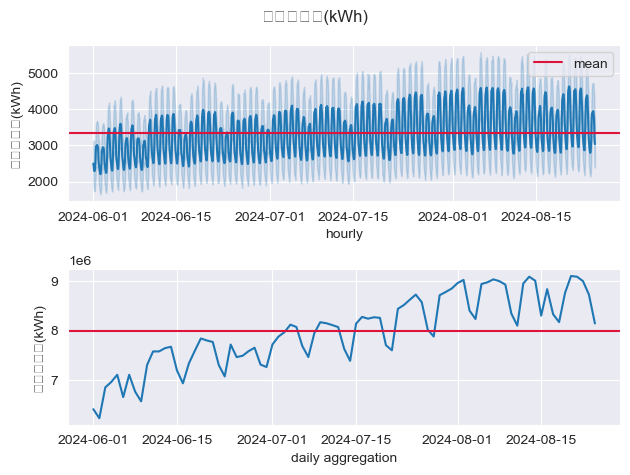

c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


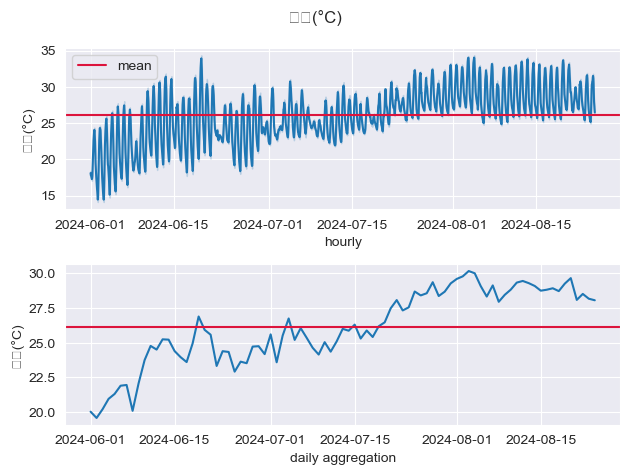

In [56]:
time_plot(df, df_daily, variable = "전력소비량(kWh)")
time_plot(df, df_daily, variable = "기온(°C)")

c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\pylabtools.py:1

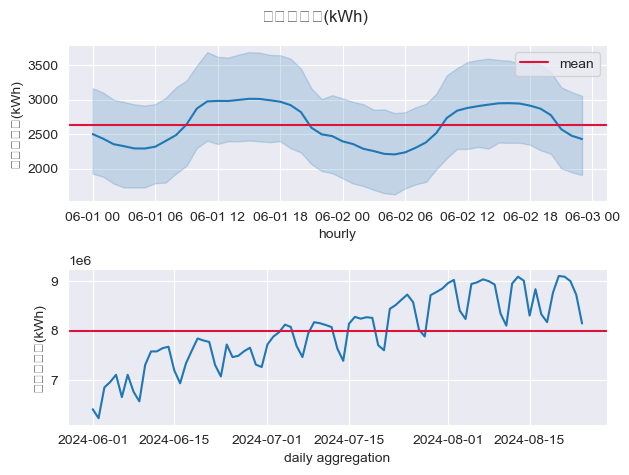

In [59]:
# 'time' 컬럼이 datetime 형식인지 확인
df['time'] = pd.to_datetime(df['time'])

# 6월 1일부터 6월 2일까지의 데이터만 선택
df_zoomed = df[df['time'] < '2024-06-03']

# 확대된 데이터로 똑같이 그래프 그리기
# 이 그래프에서는 x축에 시간 단위 눈금이 보입니다.
time_plot(df_zoomed, df_daily, variable="전력소비량(kWh)")

## Seasonal plots

c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\pylabtools.py:1

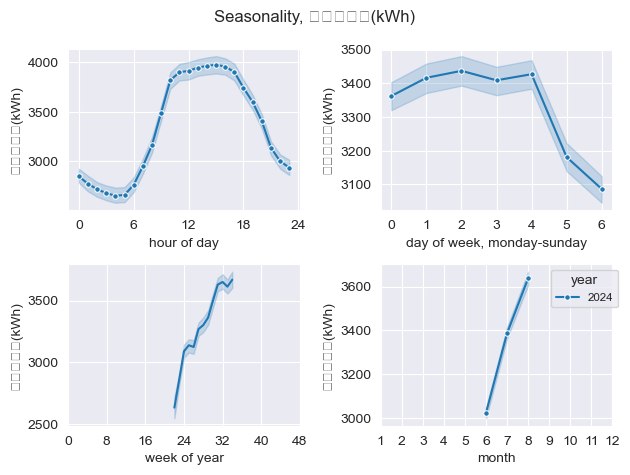

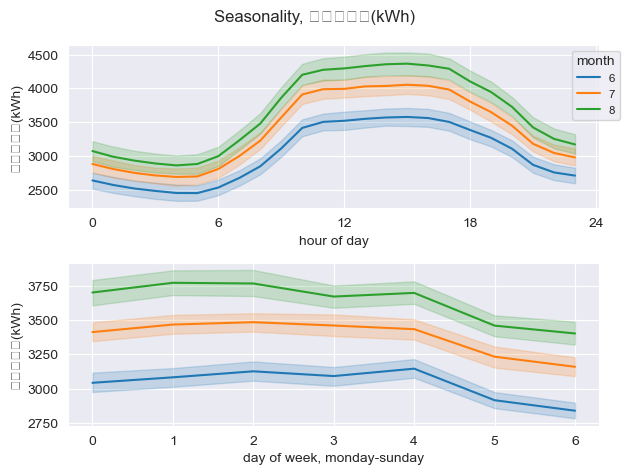

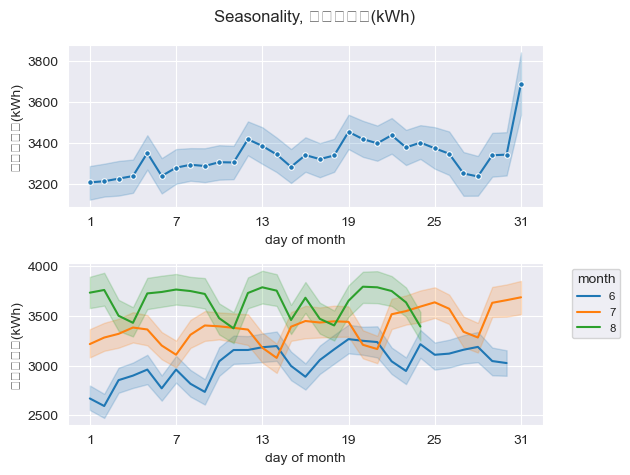

In [57]:
seasonal_plot1(df, variable = "전력소비량(kWh)", groupby_year=True)
seasonal_plot2(df, variable = "전력소비량(kWh)", groupby_month=True)
seasonal_plot3(df, variable = "전력소비량(kWh)")

## Autocorrelation plots

c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\Daniel\anaconda3\envs\aiot\lib\site-packages\IPython\core\pylabtools.py:1

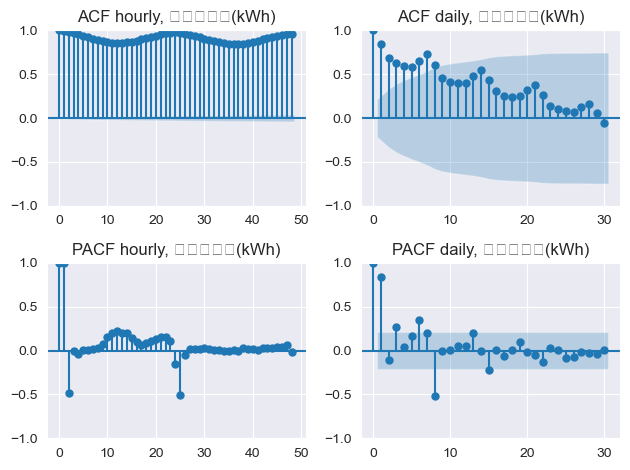

In [58]:
plot_autocorrelation(df, df_daily, variable = "전력소비량(kWh)")